In [1]:
import numpy as np
import keras.backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close() #new line lets you reset GPU memory without closing notebook
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [3]:
DATA_PATH = '/home/bfortuner/workplace/data/statefarm/'
TRAIN_PATH = DATA_PATH+'train/'
VALID_PATH = DATA_PATH+'valid/'
TEST_PATH = DATA_PATH+'test/'
WEIGHTS_PATH = DATA_PATH+'weights/'
RESULTS_PATH = DATA_PATH+'results/'
SAMPLE_PATH = DATA_PATH+'sample/'
METADATA_FILE_PATH = DATA_PATH+'driver_imgs_list.csv'

In [4]:
%cd $DATA_PATH

/home/bfortuner/workplace/data/statefarm


### Explore Data

In [5]:
from glob import glob
from shutil import copyfile
from random import randrange

In [6]:
import bcolz 
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [7]:
import pandas as pd
metadata = pd.read_csv(METADATA_FILE_PATH)
metadata.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
print(metadata['subject'].nunique())
print(metadata['subject'].unique())
print(metadata['classname'].nunique())
print(metadata['classname'].unique())
print (metadata['img'].count())

26
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']
10
['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
22424


In [9]:
metadata.groupby(['subject','classname']).count()[:10]

img
subject classname     
p002    c0          76
        c1          74
        c2          86
        c3          79
        c4          84
        c5          76
        c6          83
        c7          72
        c8          44
        c9          51

In [10]:
# How images are distributed among class-subject combos
df = metadata.groupby(['classname','subject']).count()
df['img'].mean() #mean per class-subject combo

86.24615384615385

In [11]:
# how images are distributed among subjects
df = metadata.groupby(['subject']).count()['img']
print(df.mean())
print(df)

862.4615384615385
subject
p002     725
p012     823
p014     876
p015     875
p016    1078
p021    1237
p022    1233
p024    1226
p026    1196
p035     848
p039     651
p041     605
p042     591
p045     724
p047     835
p049    1011
p050     790
p051     920
p052     740
p056     794
p061     809
p064     820
p066    1034
p072     346
p075     814
p081     823
Name: img, dtype: int64


In [12]:
# how images are distributed among classnames
df = metadata.groupby(['classname']).count()['img']
print(df.mean())
print(df)

2242.4
classname
c0    2489
c1    2267
c2    2317
c3    2346
c4    2326
c5    2312
c6    2325
c7    2002
c8    1911
c9    2129
Name: img, dtype: int64


### Prepare Validation Set

In [13]:
# Total images
metadata.count()

#Training Set - 18000 images?
#Validation Set - 4000 images?
#validation_subjects = ['p049','p066','p026','p035']

subject      22424
classname    22424
img          22424
dtype: int64

In [14]:
import os
def make_dir_if_not_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [15]:
classnames = metadata['classname'].unique()
classnames

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], dtype=object)

In [16]:
# Create Valid Directories
make_dir_if_not_exists(VALID_PATH)
for name in classnames:
    make_dir_if_not_exists(VALID_PATH+name)

In [17]:
metadata.values

array([['p002', 'c0', 'img_44733.jpg'],
       ['p002', 'c0', 'img_72999.jpg'],
       ['p002', 'c0', 'img_25094.jpg'],
       ..., 
       ['p081', 'c9', 'img_25946.jpg'],
       ['p081', 'c9', 'img_67850.jpg'],
       ['p081', 'c9', 'img_9684.jpg']], dtype=object)

In [16]:
def get_filenames_by_subject_dict():
    metadata = pd.read_csv(METADATA_FILE_PATH)
    img_dict = {}
    for row in metadata.values:
        subject,classlabel,filename = row[0],row[1],row[2]
        if subject not in img_dict:
            img_dict[subject] = {}
        if classlabel not in img_dict[subject]:
            img_dict[subject][classlabel] = []
        img_dict[subject][classlabel].append(filename)
    return img_dict
        
filenames_by_subject_dict = get_filenames_by_subject_dict()
print(filenames_by_subject_dict.keys())
print(filenames_by_subject_dict['p014'].keys())
print (len(filenames_by_subject_dict['p012']['c5']))
print (len(filenames_by_subject_dict['p012']['c0']))
print (len(filenames_by_subject_dict['p002']['c0']))
print (len(filenames_by_subject_dict['p002']['c9']))

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])
dict_keys(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
96
84
76
51


In [17]:
def get_filenames_by_class_dict():
    metadata = pd.read_csv(METADATA_FILE_PATH)
    img_dict = {}
    for row in metadata.values:
        subject,classlabel,filename = row[0],row[1],row[2]
        if classlabel not in img_dict:
            img_dict[classlabel] = {}
        if subject not in img_dict[classlabel]:
            img_dict[classlabel][subject] = []
        img_dict[classlabel][subject].append(filename)
    return img_dict
        
filenames_by_class_dict = get_filenames_by_class_dict()
print(filenames_by_class_dict.keys())
print(filenames_by_class_dict['c0'].keys())
print (len(filenames_by_class_dict['c0']['p012']))
print (len(filenames_by_class_dict['c1']['p002']))

dict_keys(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])
84
74


In [20]:
import shutil

#also need to unzip train/test images
def reset_directories():
    shutil.rmtree(VALID_PATH)
    shutil.rmtree(TRAIN_PATH)
    shutil.rmtree(SAMPLE_PATH)

reset_directories()


In [21]:
# Create Valid Directories
make_dir_if_not_exists(VALID_PATH)
for name in classnames:
    make_dir_if_not_exists(VALID_PATH+name)

In [22]:
import random 
def create_validation_set(size=4):
    #Move validation subject images to validation directory
    filenames_dict = get_filenames_by_subject_dict()
    subjects = list(filenames_dict.keys())
    random.shuffle(subjects)
    validation_subjects = subjects[:size] #['p049','p066','p026','p035']
    print (validation_subjects)
    for subject in validation_subjects:
        for cat in filenames_dict[subject].keys():
            for filename in filenames_dict[subject][cat]:
                cur_file_path = TRAIN_PATH+cat+'/'+filename
                new_file_path = VALID_PATH+cat+'/'+filename
                os.rename(cur_file_path, new_file_path)

create_validation_set(2)

['p075', 'p049']


### View Images

In [23]:
from PIL import Image
import random

def get_paths_to_files(dir_path):
    filepaths = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
    return filepaths

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path) 
    return filepaths[random.randrange(len(filepaths))]

print (get_random_image_path(TRAIN_PATH))
print (get_random_image_path(VALID_PATH))

/home/bfortuner/workplace/data/statefarm/train/c7/img_5046.jpg
/home/bfortuner/workplace/data/statefarm/valid/c2/img_77091.jpg


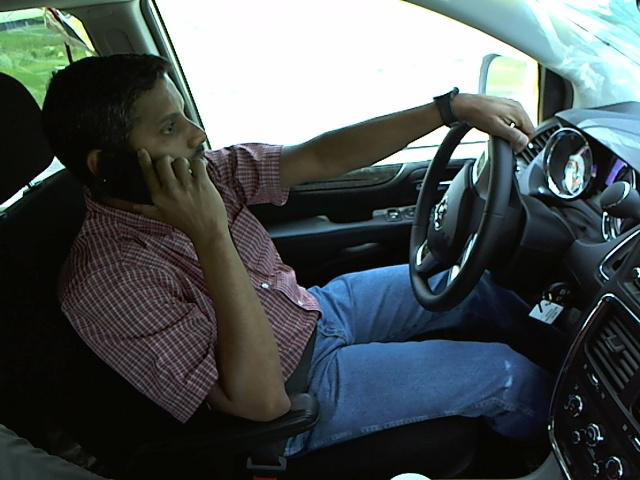

In [25]:
# View Image w Keras
from keras.preprocessing.image import load_img, img_to_array

load_img(get_random_image_path(VALID_PATH))

### Prepare Sample Set

In [26]:
SAMPLE_TRAIN_PATH = SAMPLE_PATH+'train/'
SAMPLE_VALID_PATH = SAMPLE_PATH+'valid/'

In [27]:
%mkdir $DATA_PATH/sample
%mkdir $DATA_PATH/sample/train
%mkdir $DATA_PATH/sample/valid

In [28]:
classnames

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], dtype=object)

In [29]:
#Create the Category subdirectories
for cat in classnames:
    os.mkdir(SAMPLE_TRAIN_PATH+cat)
    os.mkdir(SAMPLE_VALID_PATH+cat)

In [30]:
from shutil import copyfile

#Copy train files to sample train
%cd $TRAIN_PATH
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
print (shuf[:2])
for i in range(1500): 
    copyfile(shuf[i], SAMPLE_TRAIN_PATH + shuf[i])

/home/bfortuner/workplace/data/statefarm/train
['c8/img_4866.jpg' 'c7/img_74484.jpg']


In [31]:
#Copy valid files to sample valid
%cd $VALID_PATH
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
print (shuf[:2])
for i in range(1000): 
    copyfile(shuf[i], SAMPLE_VALID_PATH + shuf[i])

/home/bfortuner/workplace/data/statefarm/valid
['c9/img_71739.jpg' 'c9/img_31366.jpg']


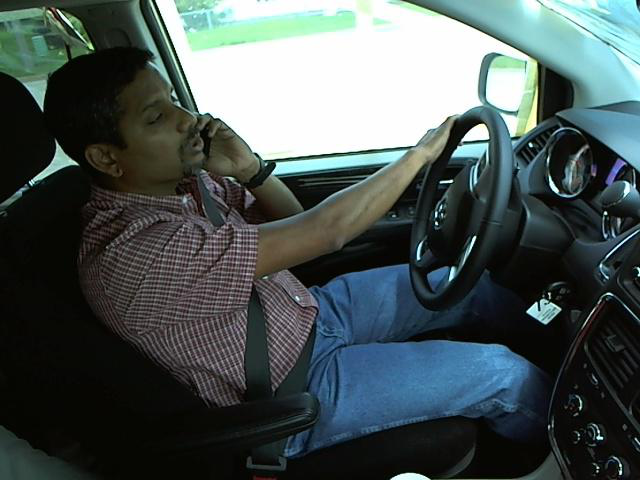

In [40]:
load_img(get_random_image_path(SAMPLE_VALID_PATH))

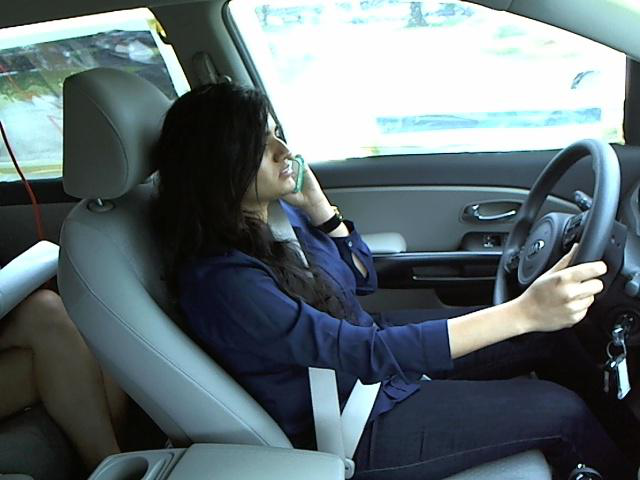

In [33]:
load_img(get_random_image_path(SAMPLE_TRAIN_PATH))

### Train

In [18]:
BATCH_SIZE = 64

In [19]:
from keras.preprocessing.image import ImageDataGenerator
img_data_gen = ImageDataGenerator()

In [20]:
train_generator = img_data_gen.flow_from_directory(
        SAMPLE_TRAIN_PATH,  # this is the target directory
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='categorical')  # multiclass categorization

valid_generator = img_data_gen.flow_from_directory(
        SAMPLE_VALID_PATH,
        target_size=(224, 224),
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')

NameError: name 'SAMPLE_TRAIN_PATH' is not defined

### Models

In [21]:
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Flatten, Convolution2D
from keras.models import Sequential
from keras.regularizers import l2

#Linear Model
model = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])

#Single Hidden Layer
model = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])

#Basic CNN
model = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])

#Deeper CNN
model = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(128,3,3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

from keras.optimizers import Adam
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.00001), metrics=['accuracy'])

In [81]:
model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.nb_sample,
        nb_epoch=2,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'first_try.h5')

Epoch 1/2
1500/1500 [==============================] - 20s - loss: 3.3069 - acc: 0.1360 - val_loss: 2.2853 - val_acc: 0.1540

In [82]:
model.optimizer.lr = 0.0001
model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.nb_sample,
        nb_epoch=4,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'second_try.h5') 

Epoch 1/4
1500/1500 [==============================] - 20s - loss: 2.2917 - acc: 0.3067 - val_loss: 2.3287 - val_acc: 0.1400

In [47]:
#Verify this isn't a total fluke
audit_generator = img_data_gen.flow_from_directory(
        SAMPLE_VALID_PATH,
        target_size=(224, 224),
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')

#Run a test on our validation data and see what happens
scores = [model.evaluate_generator(audit_generator, audit_generator.nb_sample) for i in range(5)]
np.round(scores,2)

Found 1000 images belonging to 10 classes.


array([[ 2.61,  0.41],
       [ 2.57,  0.41],
       [ 2.6 ,  0.42],
       [ 2.61,  0.41],
       [ 2.55,  0.42]])

### Data Augmentation

In [22]:
from keras.preprocessing.image import ImageDataGenerator
aug_data_gen = ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                             shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

In [23]:
aug_train_generator = aug_data_gen.flow_from_directory(
        TRAIN_PATH,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

valid_generator = img_data_gen.flow_from_directory(
        VALID_PATH,
        target_size=(224, 224),
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')

Found 20599 images belonging to 10 classes.
Found 1825 images belonging to 10 classes.


In [24]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.00001), metrics=['accuracy'])

In [25]:
model.load_weights(WEIGHTS_PATH+'first_aug_try.h5')

In [ ]:
model.fit_generator(
        aug_train_generator,
        samples_per_epoch=aug_train_generator.nb_sample,
        nb_epoch=2,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'first_aug_try.h5') 

Epoch 1/2
20599/20599 [==============================] - 179s - loss: 1.8527 - acc: 0.4249 - val_loss: 1.9753 - val_acc: 0.4071

In [ ]:
model.optimizer.lr = 0.0001
model.fit_generator(
        aug_train_generator,
        samples_per_epoch=aug_train_generator.nb_sample,
        nb_epoch=4,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'second_aug_try.h5') 

Epoch 1/4
20599/20599 [==============================] - 180s - loss: 1.5030 - acc: 0.5186 - val_loss: 1.9703 - val_acc: 0.4532

In [ ]:
model.optimizer.lr = 0.00001
model.fit_generator(
        aug_train_generator,
        samples_per_epoch=aug_train_generator.nb_sample,
        nb_epoch=10,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'fourth_aug_try.h5') 

### Predict

In [ ]:
#NEED TO MAKE THE UNKNOWN DIR

test_generator = img_data_gen.flow_from_directory(
        TEST_PATH,
        shuffle=False,
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=32,
        class_mode='categorical')  # multiclass categorization

In [ ]:
preds = model.predict_generator(test_generator, val_samples=test_generator.nb_sample, nb_worker=8)
print (len(preds))
print (preds[1])
print (preds[-1])
print (preds[70])

In [ ]:
preds[-1:]

### Submit Results To Kaggle

In [ ]:
# Example File Submission
'''
img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
'''

In [ ]:
submit_preds = preds.clip(.03,.97)
print(submit_preds[:5])

In [ ]:
print(test_generator.filenames[:3])
test_filenames = [f[8:] for f in test_generator.filenames]
print (test_filenames[:3])
print (len(test_filenames))
print (len(preds))

In [ ]:
import pandas as pd
submission = pd.DataFrame(submit_preds, columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
submission.insert(0, 'img', test_filenames)
submission.head()

In [ ]:
submit_file_name = RESULTS_PATH+'submissions.csv'
submission.to_csv(submit_file_name, index=False)#, compression='gzip')

In [ ]:
from IPython.display import FileLink
FileLink(submit_file_name)